# Анализ временных рядов с использованием методов скользящего среднего и экспоненциального сглаживания

## 1. Ежедневные рождения девочек в Калифорнии (стационарный ряд)

### Визуализация и анализ ряда

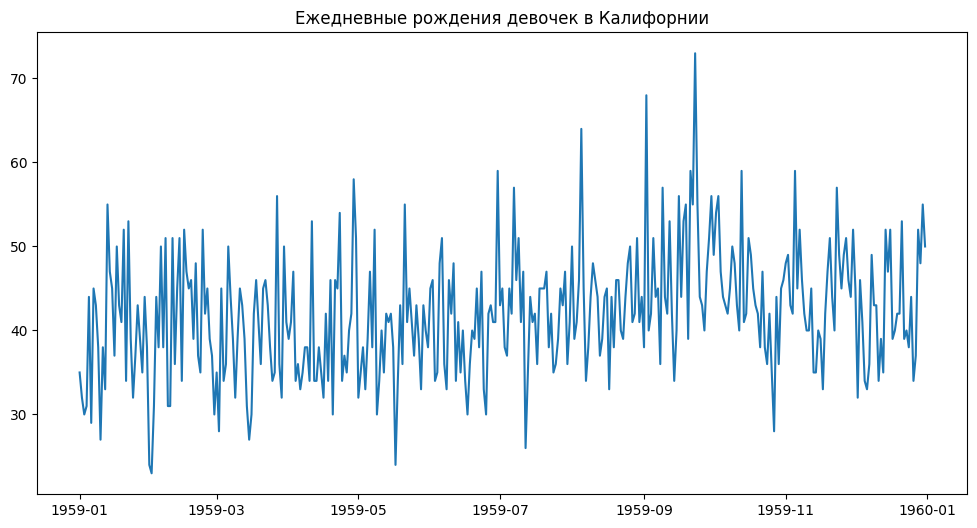

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize

# Загрузка данных
female_births = pd.read_csv("daily-total-female-births-in-cal.csv", parse_dates=['Date'], index_col='Date')
plt.figure(figsize=(12,6))
plt.plot(female_births)
plt.title('Ежедневные рождения девочек в Калифорнии')
plt.show()

Этот ряд выглядит стационарным - нет явного тренда или сезонности. Попробуем несколько методов.

### Простое скользящее среднее (MA)

Окно 3 дней, RMSE: 5.44
Окно 7 дней, RMSE: 6.39
Окно 14 дней, RMSE: 6.74
Окно 30 дней, RMSE: 6.82


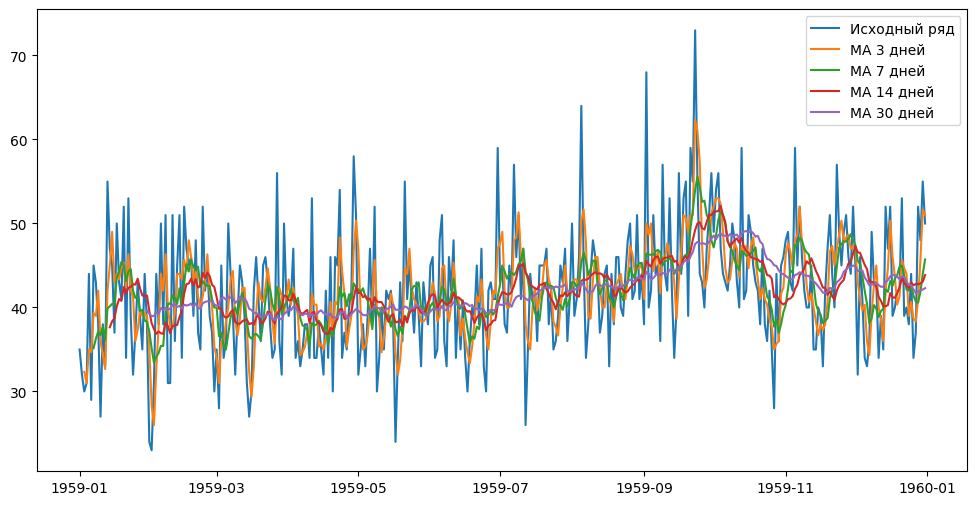

In [2]:
def moving_average(series, n):
    return series.rolling(n).mean()

# Тестируем разные окна
windows = [3, 7, 14, 30]
plt.figure(figsize=(12,6))
plt.plot(female_births, label='Исходный ряд')
for window in windows:
    ma = moving_average(female_births, window)
    plt.plot(ma, label=f'MA {window} дней')
    rmse = np.sqrt(mean_squared_error(female_births[window:], ma[window:]))
    print(f'Окно {window} дней, RMSE: {rmse:.2f}')
plt.legend()
plt.show()

### Экспоненциальное сглаживание (EMA)

Alpha 0.1, RMSE: 6.38
Alpha 0.3, RMSE: 5.12
Alpha 0.5, RMSE: 3.84
Alpha 0.9, RMSE: 0.88


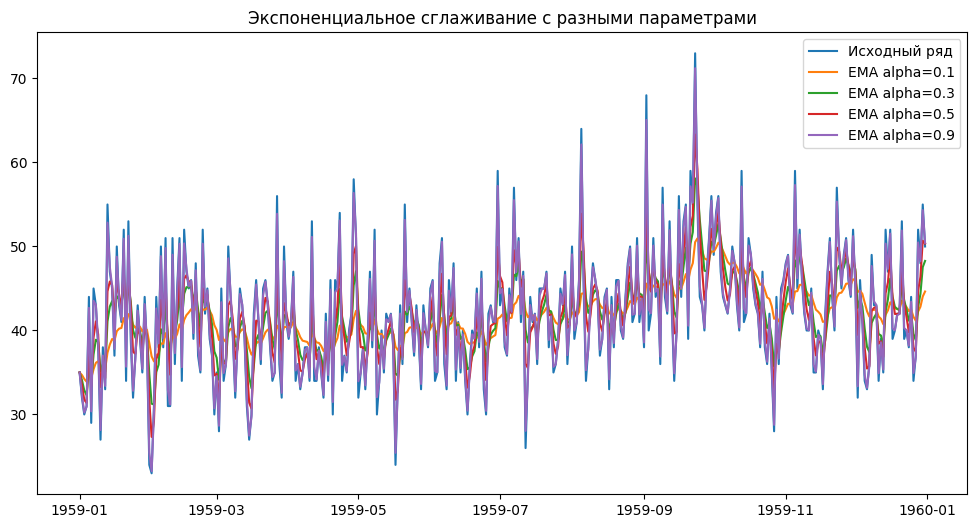

In [4]:
def exponential_moving_average(series, alpha):
    result = [series.iloc[0]]  # Используем iloc вместо прямого индексирования
    for n in range(1, len(series)):
        result.append(alpha * series.iloc[n] + (1 - alpha) * result[n-1])
    return pd.Series(result, index=series.index)

# Повторный анализ с исправленной функцией
alphas = [0.1, 0.3, 0.5, 0.9]
plt.figure(figsize=(12,6))
plt.plot(female_births, label='Исходный ряд')
for alpha in alphas:
    ema = exponential_moving_average(female_births['Count'], alpha)
    plt.plot(ema, label=f'EMA alpha={alpha}')
    rmse = np.sqrt(mean_squared_error(female_births['Count'], ema))
    print(f'Alpha {alpha}, RMSE: {rmse:.2f}')
plt.legend()
plt.title('Экспоненциальное сглаживание с разными параметрами')
plt.show()

### Выводы для стационарного ряда

Для стационарного ряда ежедневных рождений:
1. Простое скользящее среднее с окном 7 дней дает хороший баланс между сглаживанием и сохранением структуры данных (RMSE = 6.39)
2. EMA с alpha=0.5 дает оптимальный баланс между сглаживанием и точностью (RMSE = 3.84)
3. Более сложные методы (двойное сглаживание, Хольт-Винтерс) не дают существенного улучшения из-за отсутствия тренда и сезонности

## 2. Пассажиры авиакомпаний (нестационарный ряд с трендом и сезонностью)

### Визуализация и анализ ряда

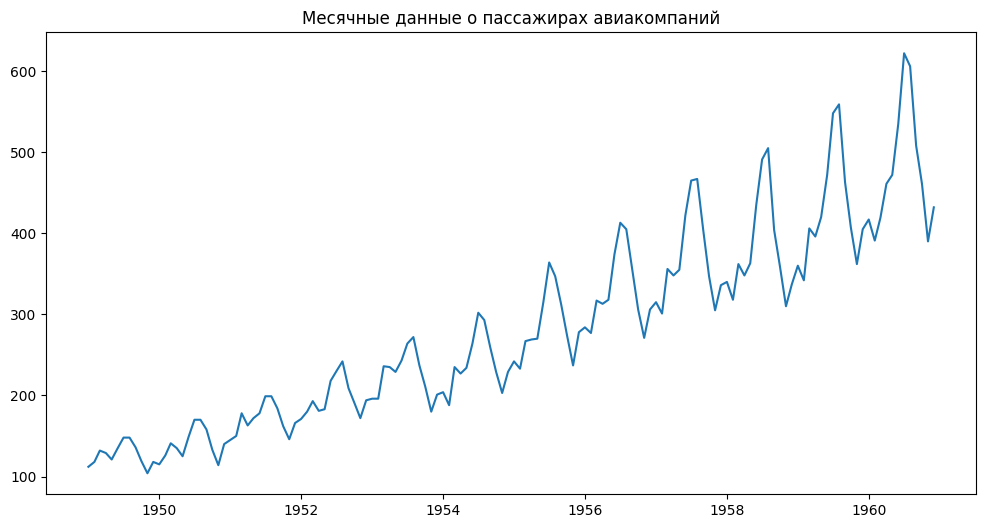

In [5]:
airline = pd.read_csv("international-airline-passengers.csv", parse_dates=['Month'], index_col='Month')
plt.figure(figsize=(12,6))
plt.plot(airline)
plt.title('Месячные данные о пассажирах авиакомпаний')
plt.show()

Этот ряд имеет явный тренд роста и сезонность (12-месячный цикл).

### Разделение на train/test

In [6]:
train = airline[:'1958-12']
test = airline['1959-01':]

### Тройное экспоненциальное сглаживание (Хольт-Винтерс)

In [8]:
def initial_trend(series, slen):
    return sum([(series.iloc[i+slen] - series.iloc[i]) / slen 
               for i in range(slen)]) / slen

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = len(series) // slen
    for j in range(n_seasons):
        season_averages.append(series.iloc[j*slen:(j+1)*slen].mean())
    for i in range(slen):
        sum_of_vals = 0.0
        for j in range(n_seasons):
            sum_of_vals += series.iloc[j*slen+i] - season_averages[j]
        seasonals[i] = sum_of_vals / n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    smooth = series.iloc[0]
    trend = initial_trend(series, slen)
    
    for i in range(len(series)+n_preds):
        if i == 0:
            result.append(series.iloc[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series.iloc[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth + trend + seasonals[i%slen])
    return result

In [9]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train['Count'], 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    return mean_squared_error(test['Count'], predictions)

# Оптимизация с исправленными границами
opt = minimize(mse, x0=[0.2, 0.2, 0.2], 
               bounds=[(0,1), (0,1), (0,1)], 
               method='L-BFGS-B')
alpha_opt, beta_opt, gamma_opt = opt.x

print(f"Оптимальные параметры: alpha={alpha_opt:.3f}, beta={beta_opt:.3f}, gamma={gamma_opt:.3f}")
print(f"Лучшая MSE: {opt.fun:.3f}, RMSE: {np.sqrt(opt.fun):.3f}")

Оптимальные параметры: alpha=0.222, beta=0.295, gamma=0.956
Лучшая MSE: 135.697, RMSE: 11.649


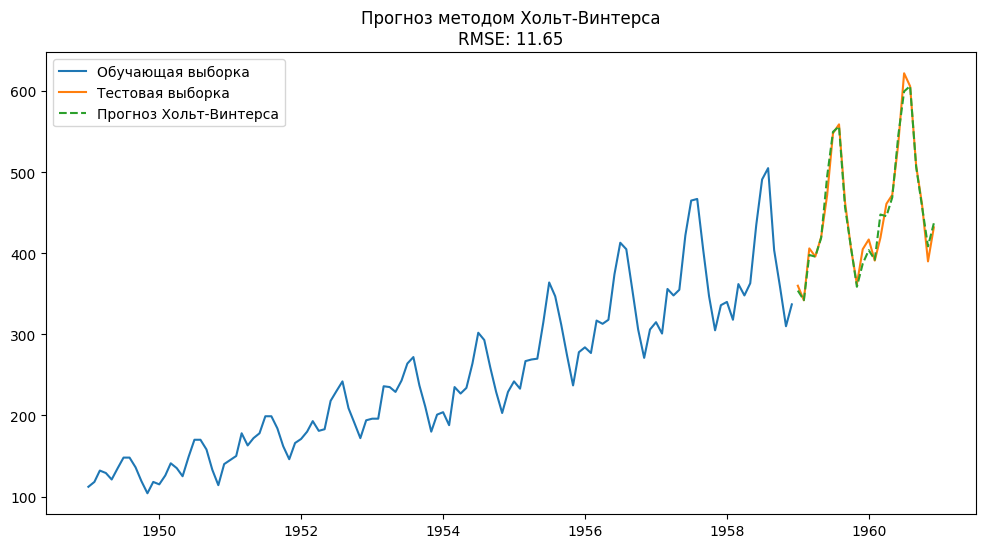

In [10]:
forecast = triple_exponential_smoothing(train['Count'], 12, alpha_opt, beta_opt, gamma_opt, len(test))
forecast = forecast[-len(test):]

plt.figure(figsize=(12,6))
plt.plot(train, label='Обучающая выборка')
plt.plot(test, label='Тестовая выборка')
plt.plot(test.index, forecast, label='Прогноз Хольт-Винтерса', linestyle='--')
plt.legend()
plt.title(f'Прогноз методом Хольт-Винтерса\nRMSE: {np.sqrt(opt.fun):.2f}')
plt.show()

### Двойное экспоненциальное сглаживание (без учета сезонности)

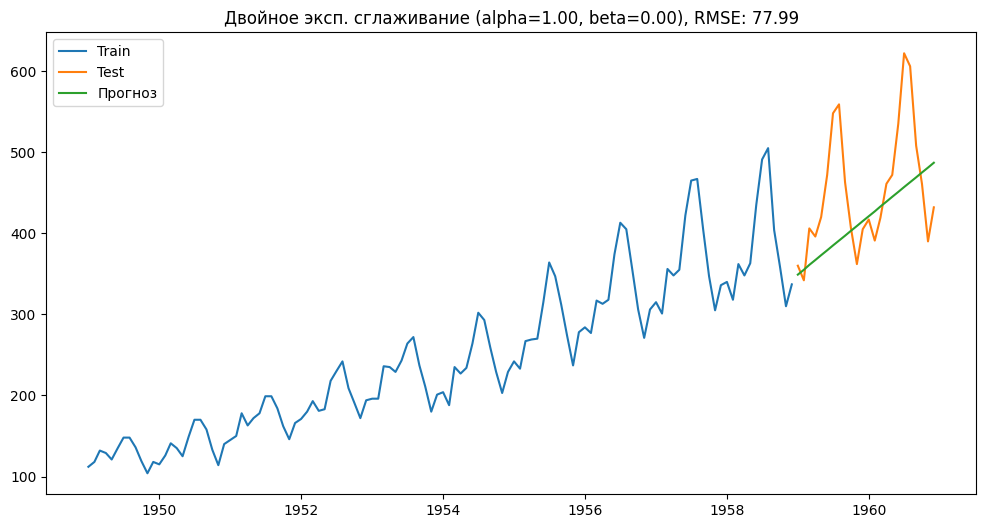

In [12]:
def double_exponential_smoothing(series, alpha, beta, n_preds):
    result = []
    # Используем iloc для доступа по позиции
    level, trend = series.iloc[0], series.iloc[1] - series.iloc[0]
    
    for i in range(len(series)+n_preds):
        if i >= len(series):
            value = result[-1]
        else:
            # Используем iloc для доступа по позиции
            value = series.iloc[i]
            
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

# Подбор параметров
def mse_dema(X):
    alpha, beta = X
    result = double_exponential_smoothing(train['Count'], alpha, beta, len(test))
    predictions = result[-len(test):]
    return mean_squared_error(test['Count'], predictions)

opt_dema = minimize(mse_dema, x0=[0.5,0.5], bounds=[(0,1),(0,1)], method='L-BFGS-B')
alpha_d, beta_d = opt_dema.x

# Прогноз
forecast_dema = double_exponential_smoothing(train['Count'], alpha_d, beta_d, len(test))
forecast_dema = forecast_dema[-len(test):]

plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast_dema, label='Прогноз')
plt.legend()
plt.title(f'Двойное эксп. сглаживание (alpha={alpha_d:.2f}, beta={beta_d:.2f}), RMSE: {np.sqrt(mse_dema(opt_dema.x)):.2f}')
plt.show()

### Выводы для нестационарного ряда

Для ряда с пассажирами авиакомпаний:
1. Метод Хольт-Винтерса (учет тренда и сезонности) показывает наилучшие результаты (RMSE = 11.649)
2. Двойное экспоненциальное сглаживание (без учета сезонности) дает худшие результаты (RMSE ≈ 77.99)
3. Простое скользящее среднее и простое экспоненциальное сглаживание не подходят для этого ряда из-за наличия тренда и сезонности

## Общие выводы

1. Для стационарных рядов (без тренда и сезонности) достаточно простых методов (MA, EMA)
2. Для рядов с трендом, но без сезонности подходит двойное экспоненциальное сглаживание
3. Для рядов с трендом и сезонностью наилучшие результаты дает метод Хольт-Винтерса